# Time Sequences: Transformers

Prateek Gulati  
11/1/2022  
CS 7180 Advanced Perception  

### Environment setup, packages and import




In [1]:
# !pip install transformers
# !pip install livelossplot 
# !pip install git+https://github.com/PetrochukM/PyTorch-NLP.git
# !pip install emoji
# !pip install seaborn
# !pip install sentencepiece
# !pip install umap-learn
# !nvidia-smi

In [1]:
from sklearn.manifold import TSNE
from umap import UMAP

from transformers import BertForSequenceClassification,BertTokenizerFast, RobertaTokenizer, RobertaForSequenceClassification, AlbertTokenizer, AlbertForSequenceClassification
import torch

from helper import *

In [2]:
torch.manual_seed(42)

### Data Source

I am using TweetEval dataset [(source)](https://github.com/cardiffnlp/tweeteval) which consists of seven heterogenous tasks in Twitter, all framed as multi-class tweet classification. All tasks have been unified into the same benchmark, with each dataset presented in the same format and with fixed training, validation and test splits. 

In [6]:
# !test -d ./tweeteval || git clone https://github.com/cardiffnlp/tweeteval ./tweeteval

In [7]:
train_df = load_df('./tweeteval/datasets/irony/train_text.txt','./tweeteval/datasets/irony/train_labels.txt').head(1500)

In [8]:
train_df.shape

(1500, 2)

## Data preprocessing
Preprocess the text data. This includes encoding urls, hashtags, emoji, removal of extra space and changing text to lower case.


In [9]:
train_df = preprocess_data_df(train_df)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Hyper-parameters for transformer model

In [11]:
BATCH_SIZE = 64 #@param [8,16,32,64] {type:"raw"}
MAX_SEQ_LEN = 50   #@param [50,100,512] {type:"raw"}

### Dimensionality Reduction
Using two techniques here, TSNE and UMAP  

In [12]:
dim_reducer_tsne = TSNE(n_components=2)
dim_reducer_umap = UMAP(n_components=2)

## Initialize tokenizer and model


Model and Tokenizer: For this I am using pre-trained model from the transformers library and respective tokenizers

### Bert

In [13]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
# tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)
# model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)
# model = AlbertForSequenceClassification.from_pretrained("albert-base-v2").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

#### Extract embeddings


I extract the embeddings from different layers of the transformer and use a dimensionality reduction to represent in a 2D plot

/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


visualize_layerwise_embeddings for TSNE


/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2


visualize_layerwise_embeddings for UMAP

CPU times: user 27min 35s, sys: 13min 46s, total: 41min 22s
Wall time: 6min 53s


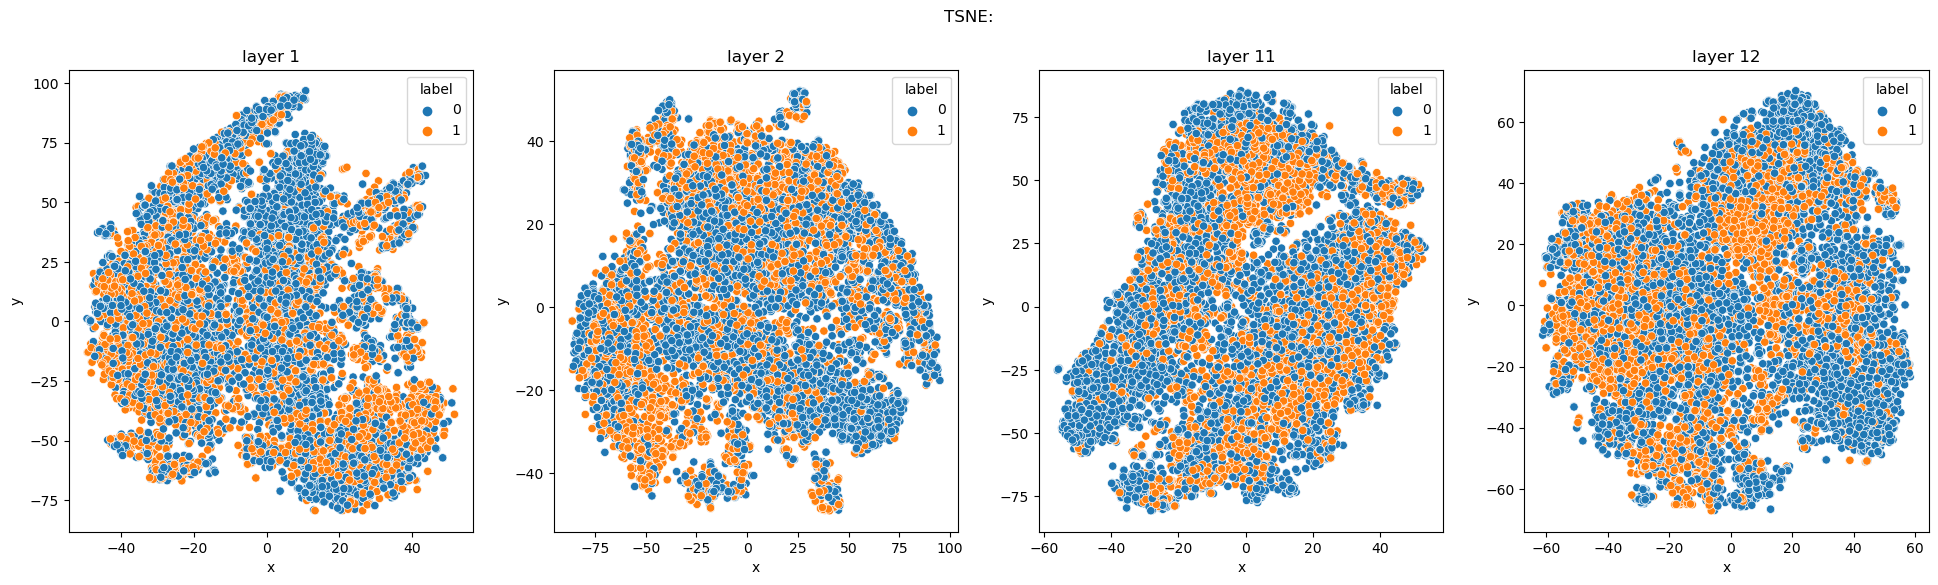

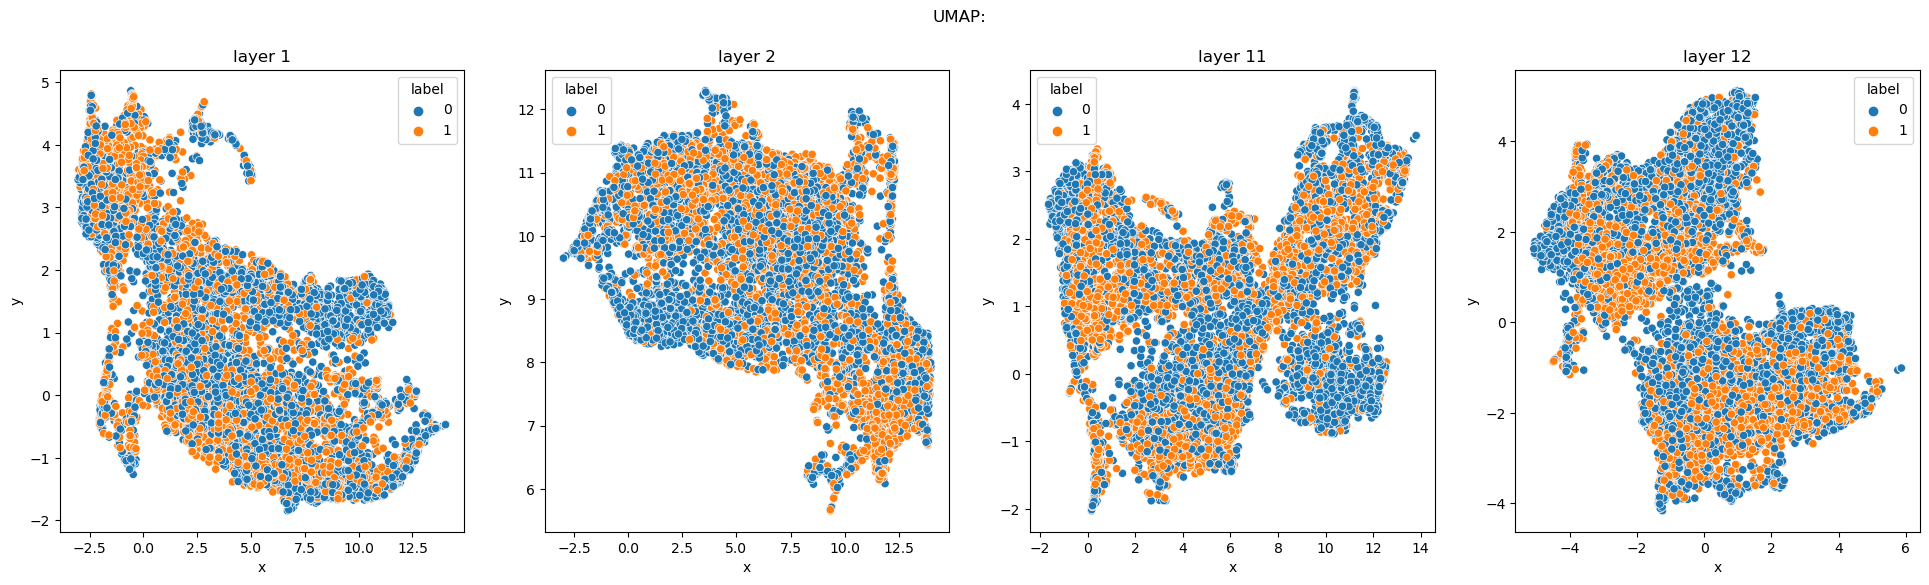

In [35]:
%%time

model.train(False)  #toggle model in eval mode
with torch.no_grad():
    train_masks,train_ys = torch.zeros(0,MAX_SEQ_LEN),torch.zeros(0,1)
    train_hidden_states = None
    for x,y in get_bert_encoded_data_in_batches(tokenizer, train_df,BATCH_SIZE,MAX_SEQ_LEN):
        sent_ids,masks = x
        sent_ids = sent_ids.to(device)
        masks = masks.to(device)
        y = y.to(device)
        model_out = model(sent_ids,masks,output_hidden_states=True,return_dict=True)
        hidden_states = model_out.hidden_states[1:]


        train_masks = torch.cat([train_masks,masks.cpu()])
        train_ys = torch.cat([train_ys,y.cpu().view(-1,1)])

        if type(train_hidden_states) == type(None):
            train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
        else:
            train_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(train_hidden_states,hidden_states))
    # print(len(train_hidden_states))
    visualize_layerwise_embeddings(dim_reducer_tsne, train_hidden_states,train_masks,train_ys,'TSNE')
    visualize_layerwise_embeddings(dim_reducer_umap, train_hidden_states,train_masks,train_ys,'UMAP')

### Roberta

In [58]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
# tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

In [59]:
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)
model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)
# model = AlbertForSequenceClassification.from_pretrained("albert-base-v2").to(device)

#### Extract embeddings


I extract the embeddings from different layers of the transformer and use a dimensionality reduction to represent in a 2D plot

/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


visualize_layerwise_embeddings for TSNE


/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2


visualize_layerwise_embeddings for UMAP

CPU times: user 27min 55s, sys: 13min 46s, total: 41min 42s
Wall time: 6min 50s


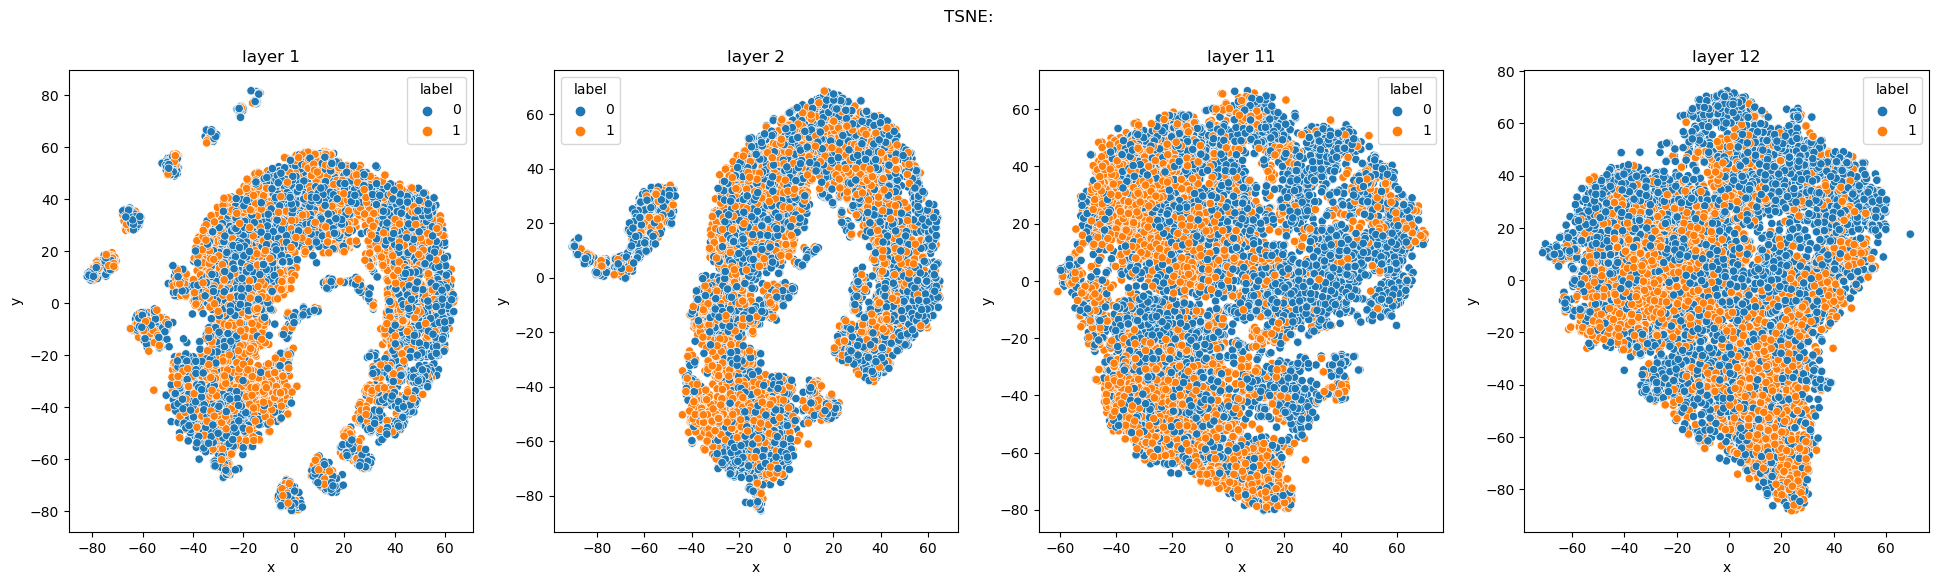

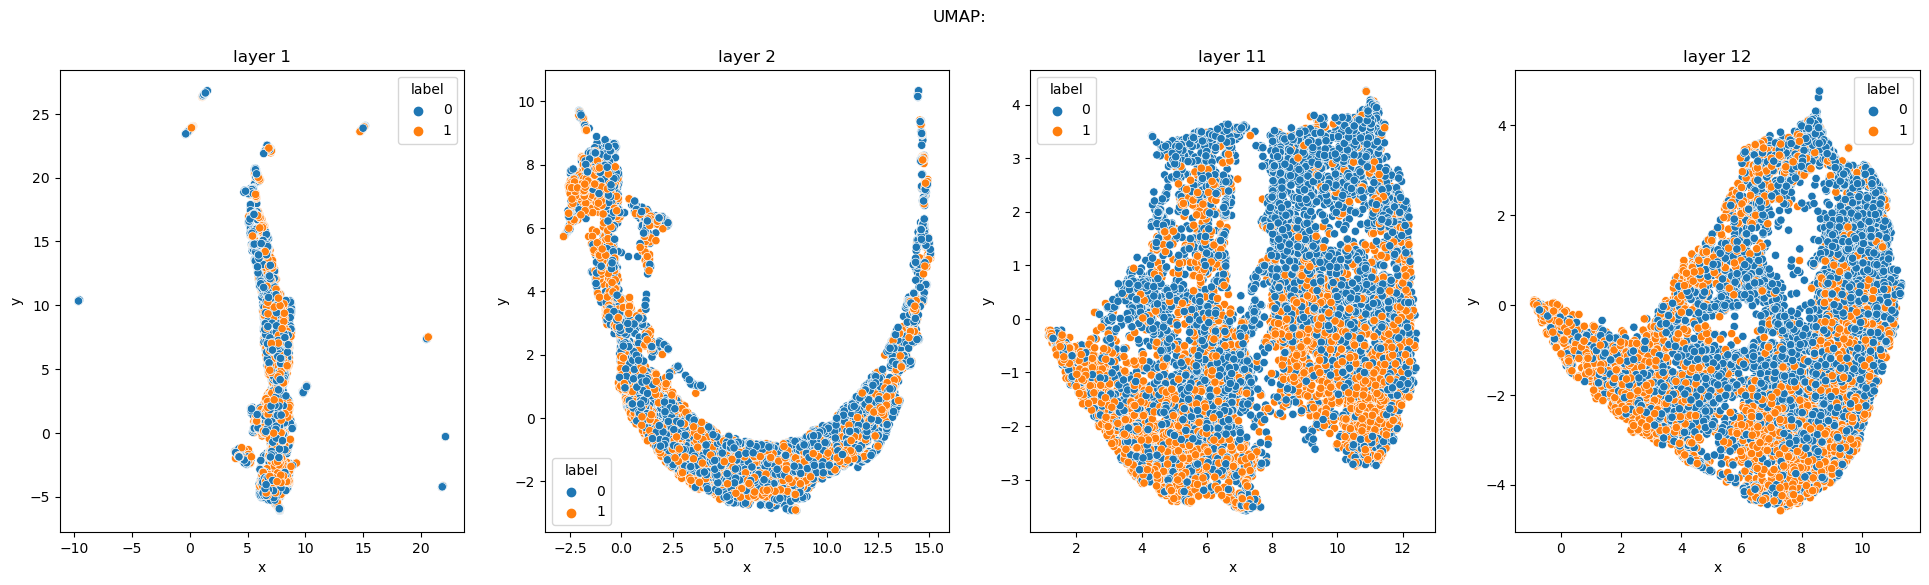

In [38]:
%%time

model.train(False)  #toggle model in eval mode
with torch.no_grad():
    train_masks,train_ys = torch.zeros(0,MAX_SEQ_LEN),torch.zeros(0,1)
    train_hidden_states = None
    for x,y in get_bert_encoded_data_in_batches(tokenizer, train_df,BATCH_SIZE,MAX_SEQ_LEN):
        sent_ids,masks = x
        sent_ids = sent_ids.to(device)
        masks = masks.to(device)
        y = y.to(device)
        model_out = model(sent_ids,masks,output_hidden_states=True,return_dict=True)
        hidden_states = model_out.hidden_states[1:]


        train_masks = torch.cat([train_masks,masks.cpu()])
        train_ys = torch.cat([train_ys,y.cpu().view(-1,1)])

        if type(train_hidden_states) == type(None):
            train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
        else:
            train_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(train_hidden_states,hidden_states))
    # print(len(train_hidden_states))
    visualize_layerwise_embeddings(dim_reducer_tsne, train_hidden_states,train_masks,train_ys,'TSNE')
    visualize_layerwise_embeddings(dim_reducer_umap, train_hidden_states,train_masks,train_ys,'UMAP')

### Albert

In [63]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

In [64]:
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased").to(device)
# model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2").to(device)

#### Extract embeddings


I extract the embeddings from different layers of the transformer and use a dimensionality reduction to represent in a 2D plot

/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


visualize_layerwise_embeddings for TSNE


/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/gulati.p/.conda/envs/cs7150/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2


visualize_layerwise_embeddings for UMAP

CPU times: user 24min 15s, sys: 13min 45s, total: 38min 1s
Wall time: 6min 17s


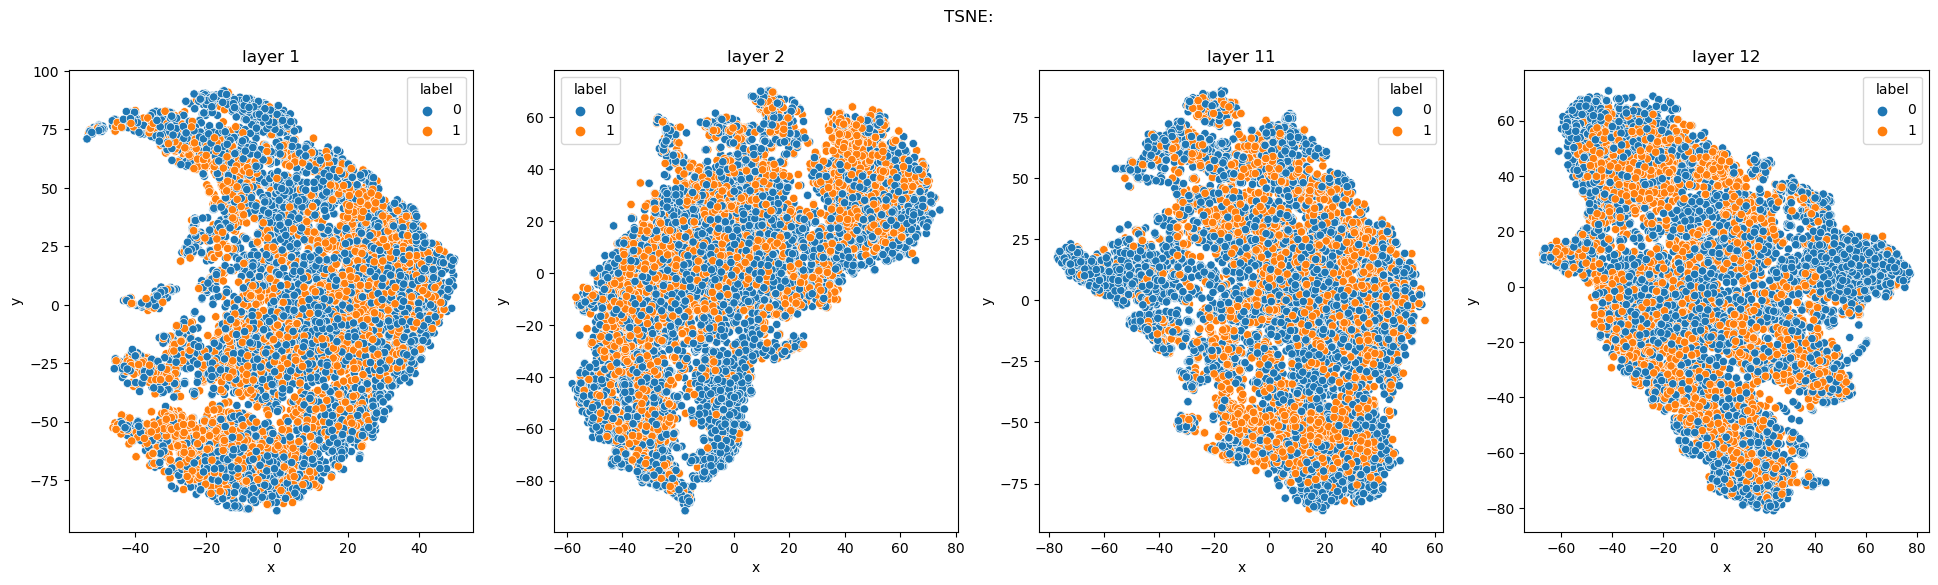

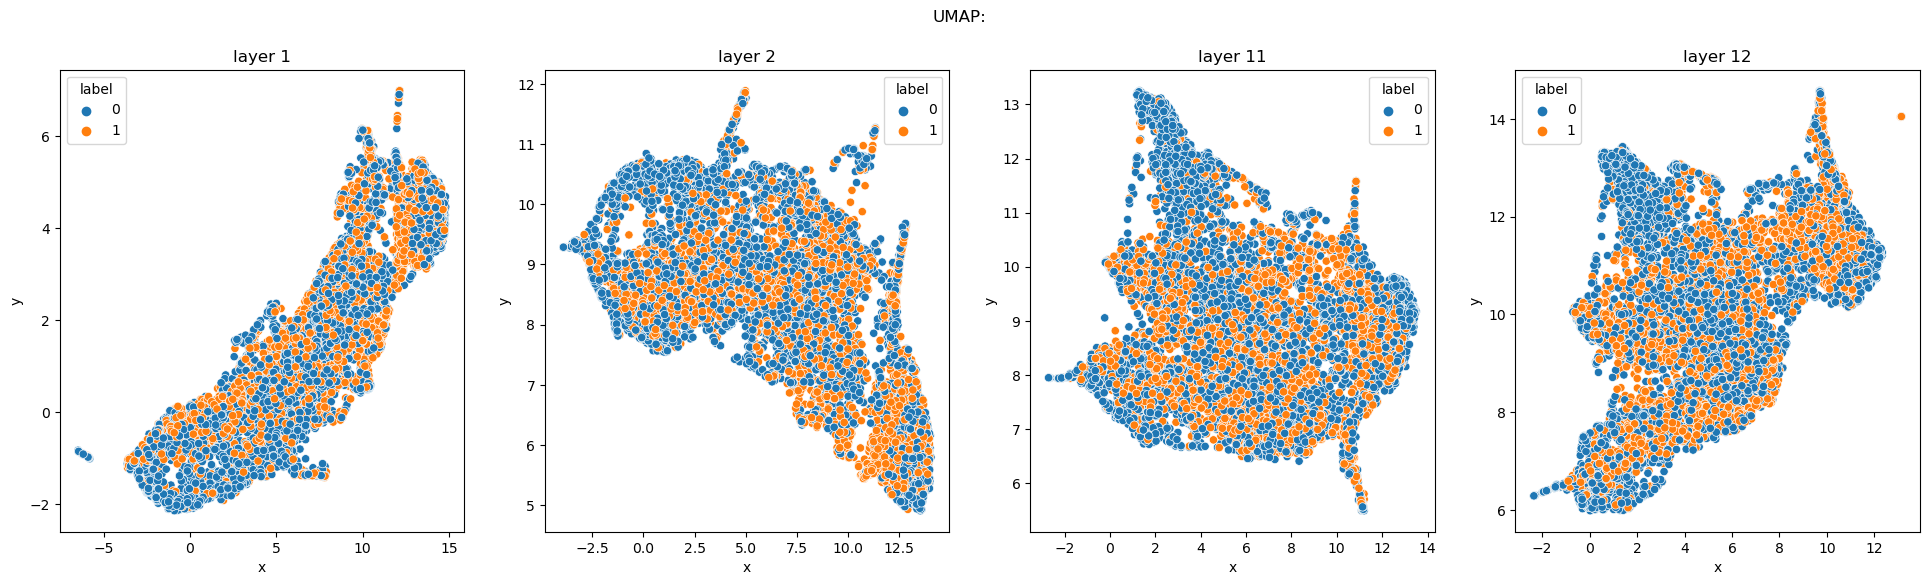

In [41]:
%%time

model.train(False)  #toggle model in eval mode
with torch.no_grad():
    train_masks,train_ys = torch.zeros(0,MAX_SEQ_LEN),torch.zeros(0,1)
    train_hidden_states = None
    for x,y in get_bert_encoded_data_in_batches(tokenizer, train_df,BATCH_SIZE,MAX_SEQ_LEN):
        sent_ids,masks = x
        sent_ids = sent_ids.to(device)
        masks = masks.to(device)
        y = y.to(device)
        model_out = model(sent_ids,masks,output_hidden_states=True,return_dict=True)
        hidden_states = model_out.hidden_states[1:]


        train_masks = torch.cat([train_masks,masks.cpu()])
        train_ys = torch.cat([train_ys,y.cpu().view(-1,1)])

        if type(train_hidden_states) == type(None):
            train_hidden_states = tuple(layer_hidden_states.cpu() for layer_hidden_states in hidden_states)
        else:
            train_hidden_states = tuple(torch.cat([layer_hidden_state_all,layer_hidden_state_batch.cpu()])for layer_hidden_state_all,layer_hidden_state_batch in zip(train_hidden_states,hidden_states))
    # print(len(train_hidden_states))
    visualize_layerwise_embeddings(dim_reducer_tsne, train_hidden_states,train_masks,train_ys,'TSNE')
    visualize_layerwise_embeddings(dim_reducer_umap, train_hidden_states,train_masks,train_ys,'UMAP')